In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
l = [0.02,0.05,0.1,0.5]
livetime = [10,8,5,4,2] * u.h
n_obs = [100,125,200,250,500]
model_name = ['PowerLaw', 'Cutoff_value = 50TeV', 'Cutoff_value = 20TeV', 'Cutoff_value = 10TeV', 'Cutoff_value = 2TeV']
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [6]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
rows, cols = (5, 5) 
model = [[0 for i in range(cols)] for j in range(rows)]
print(model) 

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [8]:
for i in range(5):
    model_simu = PowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
    )
    print(model_simu) 
    mod = SkyModel(spectral_model=model_simu)
    model[i][0]=mod

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --

In [9]:
simu = []
for j in range(4):
    for i in range(5):
        sim = ExpCutoffPowerLawSpectralModel(
            index=2.22,
            amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
            reference=1 * u.TeV,
            lambda_=l[j] * u.Unit("TeV-1"),
            alpha = 1,
        )
        mod = SkyModel(spectral_model=sim)
        model[i][j+1]=mod
    simu.append(sim)
    print(simu[j])

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    inde

In [10]:
obs = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        obs[i][j]=Observation.create(pointing=pointing, livetime=livetime[i], irfs=irfs)
        print(obs[i][j])

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 14400.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 14400.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s

Info for OBS

In [11]:
dataset = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset_empty = SpectrumDataset.create(
            e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
        )
        maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
        dataset[i][j]=maker.run(dataset_empty, obs[i][j])
        print(dataset[i][j])

SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 0 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 0 
    Number of fit bins 

SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 883.56

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 7.20e+03 s

    Number of total bins            : 0 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 0 
    Number of fit bins  

In [12]:
data = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset[i][j].model = model[i][j]
        dataset[i][j].fake(random_state=42)
        print(dataset[i][j])
        data[i][j]=dataset[i][j]

SpectrumDataset

    Name                            : 1 

    Total counts                    : 4378 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit b

In [13]:
data_onoff = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset_onoff = SpectrumDatasetOnOff(
            aeff=data[i][j].aeff,
            edisp=data[i][j].edisp,
            models=model[i][j],
            livetime=livetime[i],
            acceptance=1,
            acceptance_off=5,
        )
        dataset_onoff.fake(background_model=data[i][j].background)
        print(dataset_onoff)
        data_onoff[i][j]=dataset_onoff

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 7895 
    Total predicted counts          : 7905.29
    Total off counts                : 22085.00

    Total background counts         : 4417.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 48.27

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 6224 
    Total predicted counts          : 6354.23
    Total off counts                : 17818.00

    Total background counts         : 3563.60

    Eff

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 3959 
    Total predicted counts          : 3823.22
    Total off counts                : 10843.00

    Total background counts         : 2168.60

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 5.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 35.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 3034 
    Total predicted counts          : 3102.30
    Total off counts                : 8893.00

    Total background counts         : 1778.60

    Effe

In [14]:
%%time
datas = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        datasets = []
        for idx in range(n_obs[i]):
            data_onoff[i][j].fake(random_state=idx, background_model=data[i][j].background)
            data_onoff[i][j].name = f"obs_{idx}"
            datasets.append(data_onoff[i][j].copy())
        datas[i][j]=datasets

CPU times: user 21.7 s, sys: 308 ms, total: 22 s
Wall time: 22 s


In [15]:
print(*datas[0][0], sep = "\n")
print(*datas[4][4], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 8090 
    Total predicted counts          : 7925.69
    Total off counts                : 22187.00

    Total background counts         : 4437.40

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 42.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 7834 
    Total predicted counts          : 7917.69
    Total off counts                : 22147.00

    Total background counts         : 4429.4

SpectrumDatasetOnOff

    Name                            : obs_22 

    Total counts                    : 7991 
    Total predicted counts          : 7954.49
    Total off counts                : 22331.00

    Total background counts         : 4466.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 38.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_23 

    Total counts                    : 7934 
    Total predicted counts          : 7949.29
    Total off counts                : 22305.00

    Total background counts         : 4461

SpectrumDatasetOnOff

    Name                            : obs_35 

    Total counts                    : 8071 
    Total predicted counts          : 7929.49
    Total off counts                : 22206.00

    Total background counts         : 4441.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_36 

    Total counts                    : 7984 
    Total predicted counts          : 7912.49
    Total off counts                : 22121.00

    Total background counts         : 4424

SpectrumDatasetOnOff

    Name                            : obs_53 

    Total counts                    : 7909 
    Total predicted counts          : 7961.09
    Total off counts                : 22364.00

    Total background counts         : 4472.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 44.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_54 

    Total counts                    : 7893 
    Total predicted counts          : 7929.29
    Total off counts                : 22205.00

    Total background counts         : 4441

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 7938 
    Total predicted counts          : 7907.09
    Total off counts                : 22094.00

    Total background counts         : 4418.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 50.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_79 

    Total counts                    : 7966 
    Total predicted counts          : 7865.89
    Total off counts                : 21888.00

    Total background counts         : 4377

SpectrumDatasetOnOff

    Name                            : obs_6 

    Total counts                    : 1475 
    Total predicted counts          : 1410.60
    Total off counts                : 4393.00

    Total background counts         : 878.60

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 23.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_7 

    Total counts                    : 1403 
    Total predicted counts          : 1413.20
    Total off counts                : 4406.00

    Total background counts         : 881.20

 

SpectrumDatasetOnOff

    Name                            : obs_33 

    Total counts                    : 1465 
    Total predicted counts          : 1421.00
    Total off counts                : 4445.00

    Total background counts         : 889.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 32.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_34 

    Total counts                    : 1417 
    Total predicted counts          : 1421.20
    Total off counts                : 4446.00

    Total background counts         : 889.20


SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 1328 
    Total predicted counts          : 1392.80
    Total off counts                : 4304.00

    Total background counts         : 860.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 30.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 1402 
    Total predicted counts          : 1407.40
    Total off counts                : 4377.00

    Total background counts         : 875.40


SpectrumDatasetOnOff

    Name                            : obs_93 

    Total counts                    : 1426 
    Total predicted counts          : 1427.20
    Total off counts                : 4476.00

    Total background counts         : 895.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 29.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_94 

    Total counts                    : 1471 
    Total predicted counts          : 1407.80
    Total off counts                : 4379.00

    Total background counts         : 875.80


SpectrumDatasetOnOff

    Name                            : obs_122 

    Total counts                    : 1381 
    Total predicted counts          : 1416.20
    Total off counts                : 4421.00

    Total background counts         : 884.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 27.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 1409 
    Total predicted counts          : 1415.60
    Total off counts                : 4418.00

    Total background counts         : 883.6

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 1391 
    Total predicted counts          : 1423.00
    Total off counts                : 4455.00

    Total background counts         : 891.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 37.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_148 

    Total counts                    : 1390 
    Total predicted counts          : 1426.00
    Total off counts                : 4470.00

    Total background counts         : 894.0

SpectrumDatasetOnOff

    Name                            : obs_161 

    Total counts                    : 1473 
    Total predicted counts          : 1405.80
    Total off counts                : 4369.00

    Total background counts         : 873.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 1444 
    Total predicted counts          : 1419.00
    Total off counts                : 4435.00

    Total background counts         : 887.0

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 1400 
    Total predicted counts          : 1411.80
    Total off counts                : 4399.00

    Total background counts         : 879.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 1478 
    Total predicted counts          : 1438.20
    Total off counts                : 4531.00

    Total background counts         : 906.2

SpectrumDatasetOnOff

    Name                            : obs_204 

    Total counts                    : 1469 
    Total predicted counts          : 1401.80
    Total off counts                : 4349.00

    Total background counts         : 869.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 43.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_205 

    Total counts                    : 1459 
    Total predicted counts          : 1427.60
    Total off counts                : 4478.00

    Total background counts         : 895.6

SpectrumDatasetOnOff

    Name                            : obs_225 

    Total counts                    : 1398 
    Total predicted counts          : 1405.20
    Total off counts                : 4366.00

    Total background counts         : 873.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_226 

    Total counts                    : 1410 
    Total predicted counts          : 1426.40
    Total off counts                : 4472.00

    Total background counts         : 894.4

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 1401 
    Total predicted counts          : 1398.80
    Total off counts                : 4334.00

    Total background counts         : 866.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 36.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_244 

    Total counts                    : 1384 
    Total predicted counts          : 1410.00
    Total off counts                : 4390.00

    Total background counts         : 878.0

SpectrumDatasetOnOff

    Name                            : obs_261 

    Total counts                    : 1446 
    Total predicted counts          : 1414.80
    Total off counts                : 4414.00

    Total background counts         : 882.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_262 

    Total counts                    : 1412 
    Total predicted counts          : 1430.60
    Total off counts                : 4493.00

    Total background counts         : 898.6

SpectrumDatasetOnOff

    Name                            : obs_284 

    Total counts                    : 1399 
    Total predicted counts          : 1423.60
    Total off counts                : 4458.00

    Total background counts         : 891.60

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 1368 
    Total predicted counts          : 1422.80
    Total off counts                : 4454.00

    Total background counts         : 890.8

SpectrumDatasetOnOff

    Name                            : obs_318 

    Total counts                    : 1361 
    Total predicted counts          : 1399.80
    Total off counts                : 4339.00

    Total background counts         : 867.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_319 

    Total counts                    : 1426 
    Total predicted counts          : 1433.40
    Total off counts                : 4507.00

    Total background counts         : 901.4

SpectrumDatasetOnOff

    Name                            : obs_341 

    Total counts                    : 1437 
    Total predicted counts          : 1424.40
    Total off counts                : 4462.00

    Total background counts         : 892.40

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 1430 
    Total predicted counts          : 1422.20
    Total off counts                : 4451.00

    Total background counts         : 890.2

SpectrumDatasetOnOff

    Name                            : obs_365 

    Total counts                    : 1407 
    Total predicted counts          : 1423.20
    Total off counts                : 4456.00

    Total background counts         : 891.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_366 

    Total counts                    : 1374 
    Total predicted counts          : 1416.80
    Total off counts                : 4424.00

    Total background counts         : 884.8

SpectrumDatasetOnOff

    Name                            : obs_400 

    Total counts                    : 1474 
    Total predicted counts          : 1427.00
    Total off counts                : 4475.00

    Total background counts         : 895.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 1399 
    Total predicted counts          : 1412.20
    Total off counts                : 4401.00

    Total background counts         : 880.2

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 1417 
    Total predicted counts          : 1434.00
    Total off counts                : 4510.00

    Total background counts         : 902.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 22.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_432 

    Total counts                    : 1397 
    Total predicted counts          : 1419.40
    Total off counts                : 4437.00

    Total background counts         : 887.4

SpectrumDatasetOnOff

    Name                            : obs_465 

    Total counts                    : 1443 
    Total predicted counts          : 1411.20
    Total off counts                : 4396.00

    Total background counts         : 879.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_466 

    Total counts                    : 1463 
    Total predicted counts          : 1417.80
    Total off counts                : 4429.00

    Total background counts         : 885.8

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


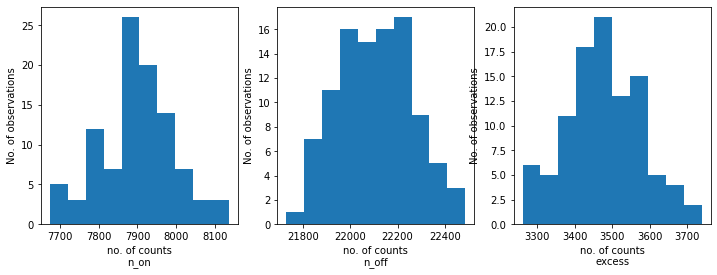

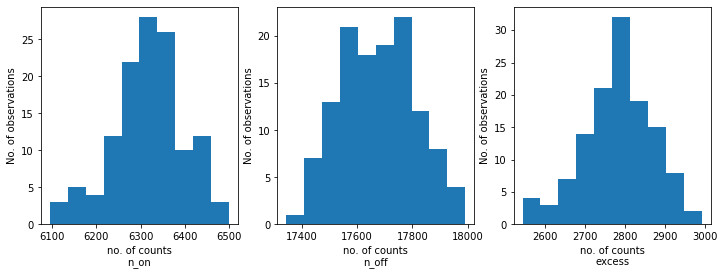

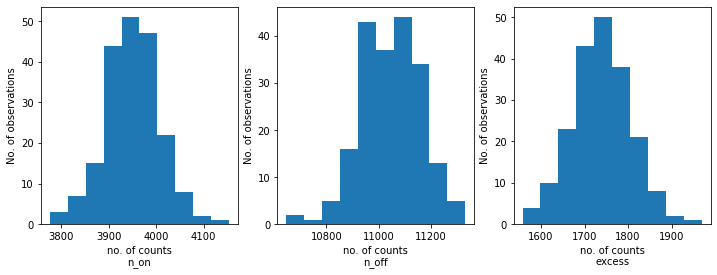

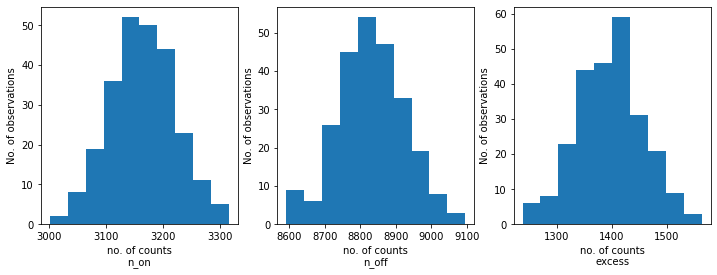

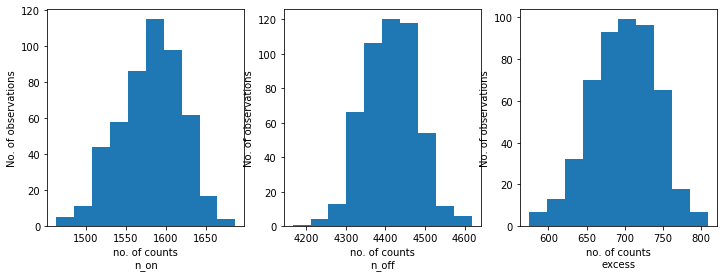

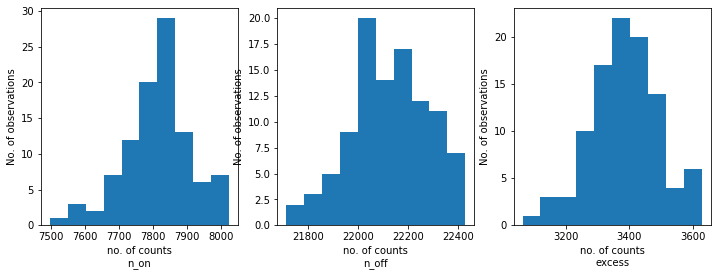

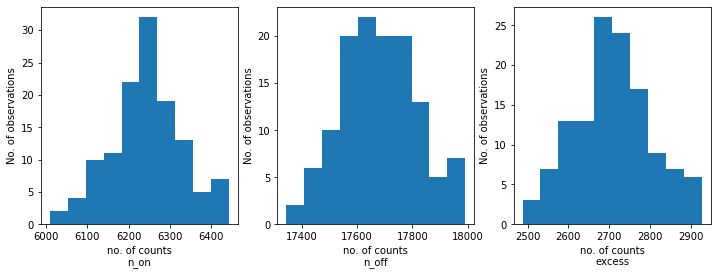

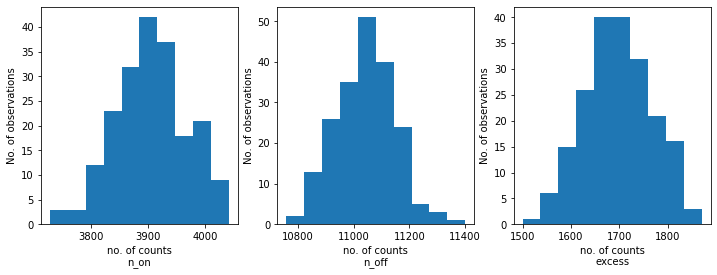

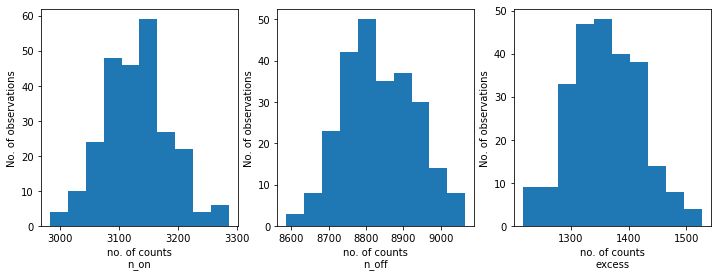

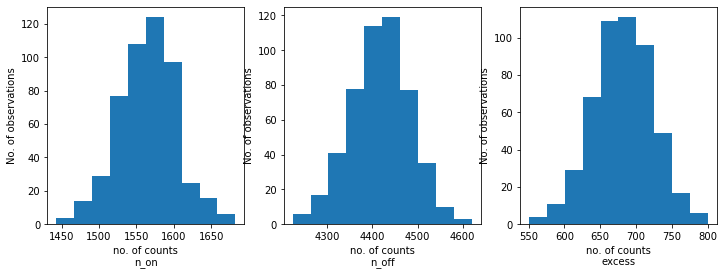

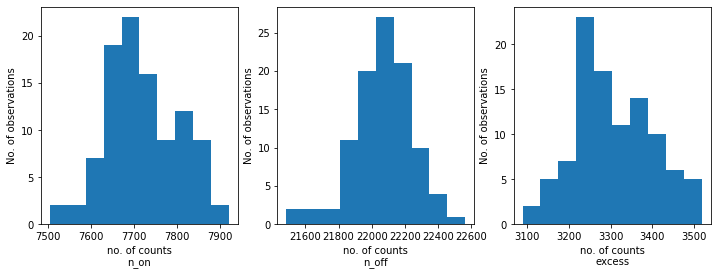

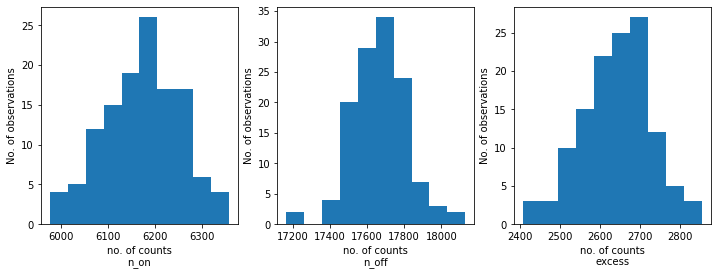

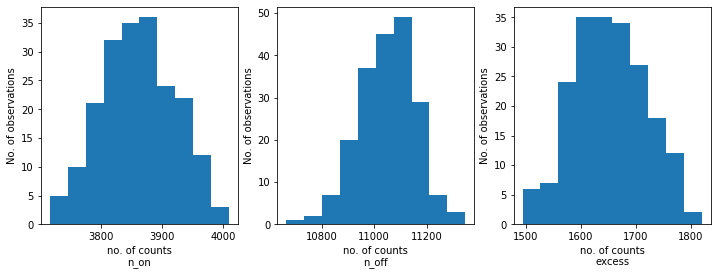

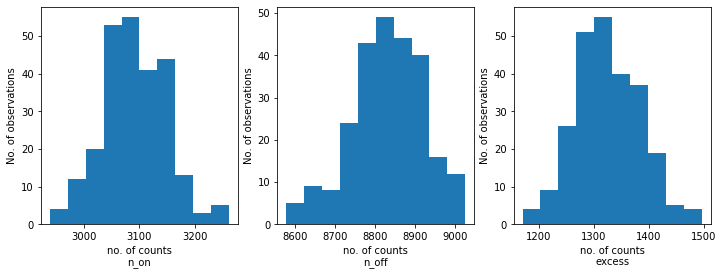

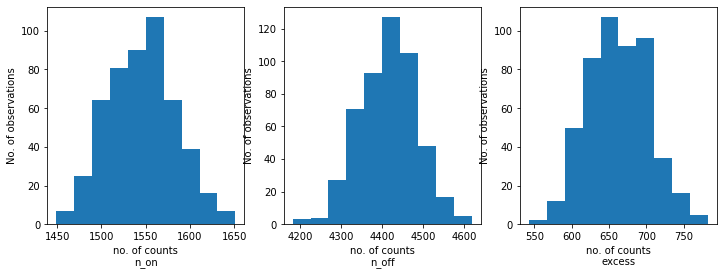

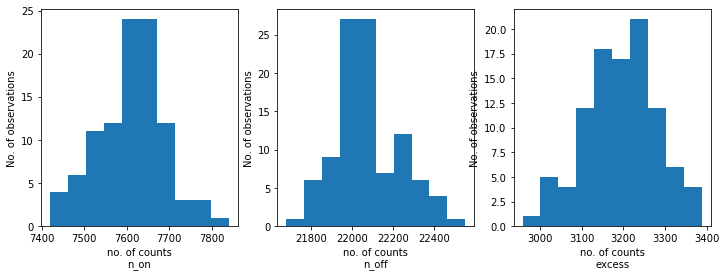

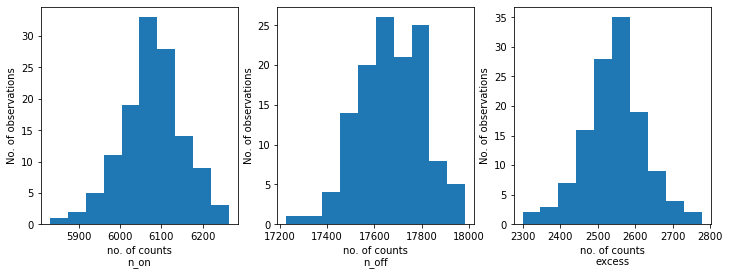

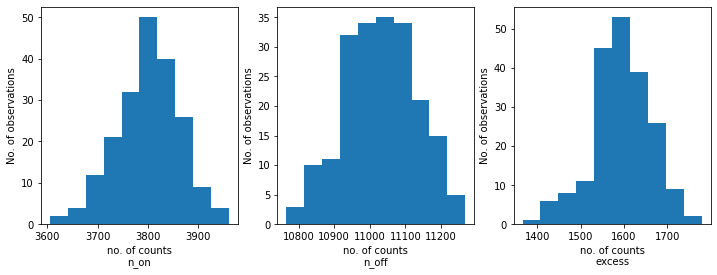

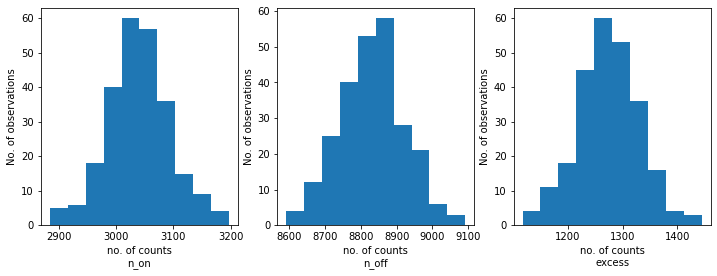

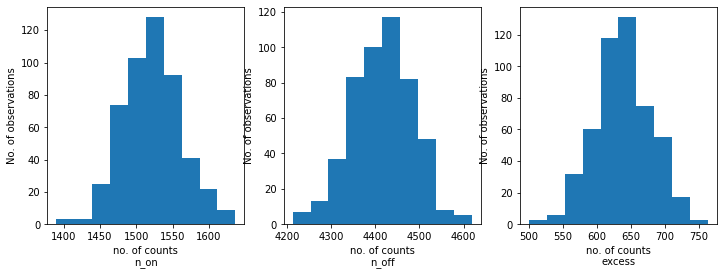

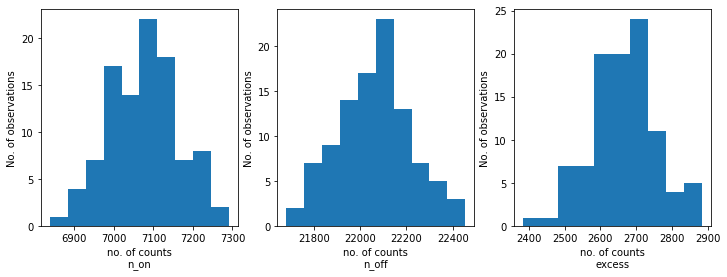

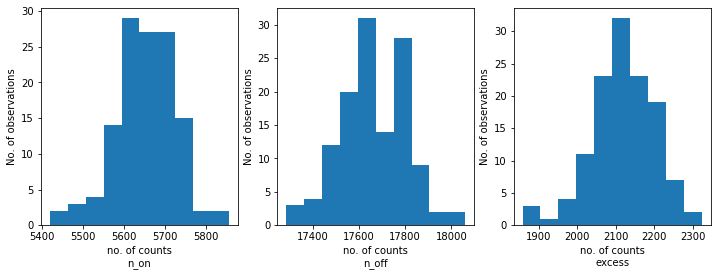

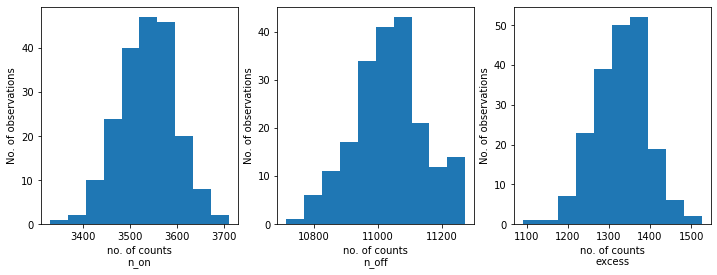

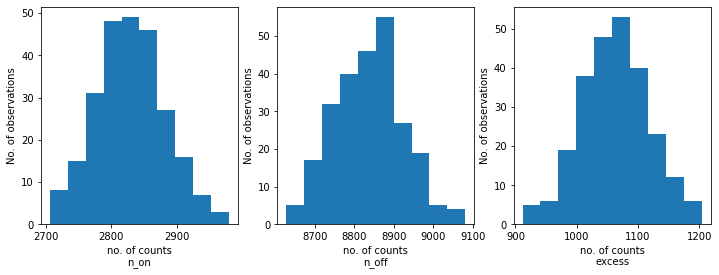

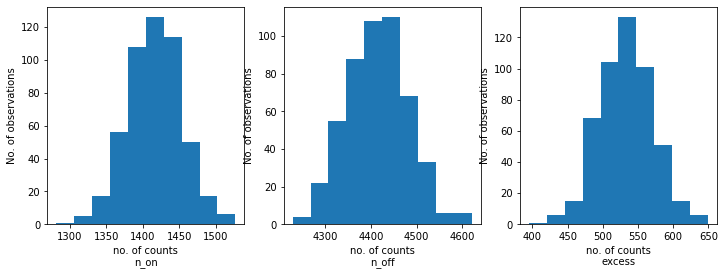

In [16]:
for j in range(5):
    for i in range(5):
        n_on = [dataset.counts.data.sum() for dataset in datas[i][j]]
        n_off = [dataset.counts_off.data.sum() for dataset in datas[i][j]]
        excess = [dataset.excess.data.sum() for dataset in datas[i][j]]
        
        fix, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].hist(n_on)
        axes[0].set_xlabel("no. of counts\nn_on")
        axes[0].set_ylabel("No. of observations")
        axes[1].hist(n_off)
        axes[1].set_xlabel("no. of counts\nn_off")
        axes[1].set_ylabel("No. of observations")
        axes[2].hist(excess)
        axes[2].set_xlabel("no. of counts\nexcess");
        axes[2].set_ylabel("No. of observations")

In [17]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [18]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

In [19]:
%%time
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
results = [[0 for i in range(cols)] for j in range(rows)]
fpes = [[0 for i in range(cols)] for j in range(rows)]
model_best_joints = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        st = datas[i][j][0]
        for ogs in datas[i][j][1:]:
            st.stack(ogs)
        
        print(st.livetime)
        st.models = model[i][j].copy()
        fit = Fit([st])
        result = fit.run()
        
        print(result.parameters.to_table())
        print(result)
        fpe = FluxPointsEstimator(datasets=[st], e_edges=e_edges)
        flux_points = fpe.run()
        print(flux_points.table_formatted)
        model_best_joint = model[i][j].copy()
        model_best_joint.spectral_model.parameters.covariance = (result.parameters.covariance)
        results[i][j] = result
        fpes[i][j] = flux_points
        model_best_joints[i][j] = model_best_joint

1000.0 h
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 1.445e-03                nan nan  False
amplitude 1.289e-12 3.075e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : 36.03

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.799e-12       9.789e-12       9.809e-12
 0.121  0.072   0.203 ...       6.558e-13       6.547e-13       6.570e-13
 0.307  0.203   0.464 ...       8.902e-14       8.910e-14       8.894e-14
 0.702  0.464   1.061 ...       1.575e-14       1.577e-14       1.573e-14
 1.778

1000.0 h
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 2.031e-03                nan nan  False
amplitude 1.287e-12 4.178e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.975e-02 7.026e-04          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 57
	total stat : 39.65

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.790e-12       9.773e-12       9.810e-12
 0.121  0.072   0.203 ...       6.550e-13       6.548e-13       6.551e-13
 0.307  0.203   0.464 ...       8.

1000.0 h
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.221e+00 2.300e-03                nan nan  False
amplitude 1.284e-12 4.890e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 4.912e-02 1.124e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 60
	total stat : 33.56

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.817e-12       9.813e-12       9.817e-12
 0.121  0.072   0.203 ...       6.550e-13       6.548e-13       6.552e-13
 0.307  0.203   0.464 ...       8.

1000.0 h
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.219e+00 2.703e-03                nan nan  False
amplitude 1.290e-12 6.064e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.006e-01 1.843e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 64
	total stat : 31.53

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.809e-12       9.812e-12       9.807e-12
 0.121  0.072   0.203 ...       6.543e-13       6.546e-13       6.541e-13
 0.307  0.203   0.464 ...       8.

1000.0 h
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.222e+00 4.767e-03                nan nan  False
amplitude 1.287e-12 1.297e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 4.975e-01 7.609e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 62
	total stat : 17.28

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.816e-12       9.804e-12       9.824e-12
 0.121  0.072   0.203 ...       6.504e-13       6.500e-13       6.508e-13
 0.307  0.203   0.464 ...       8.

In [20]:
sim = [[0 for i in range(cols)] for j in range(rows)]
for i in range(5):
    s = PowerLawSpectralModel(
        index=results[i][0].parameters["index"].value,
        amplitude=results[i][0].parameters["amplitude"].value * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
    )
    print(s) 
    sim[i][0]=s
    
for j in range(4):
    for i in range(5):
        s = ExpCutoffPowerLawSpectralModel(
            index=results[i][j+1].parameters["index"].value,
            amplitude=results[i][j+1].parameters["amplitude"].value * u.Unit("cm-2 s-1 TeV-1"),
            reference=1 * u.TeV,
            lambda_=results[i][j+1].parameters["lambda_"].value * u.Unit("TeV-1"),
            alpha = 1,
        )
        print(s)
        sim[i][j+1]=s

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --

<function matplotlib.pyplot.show(*args, **kw)>

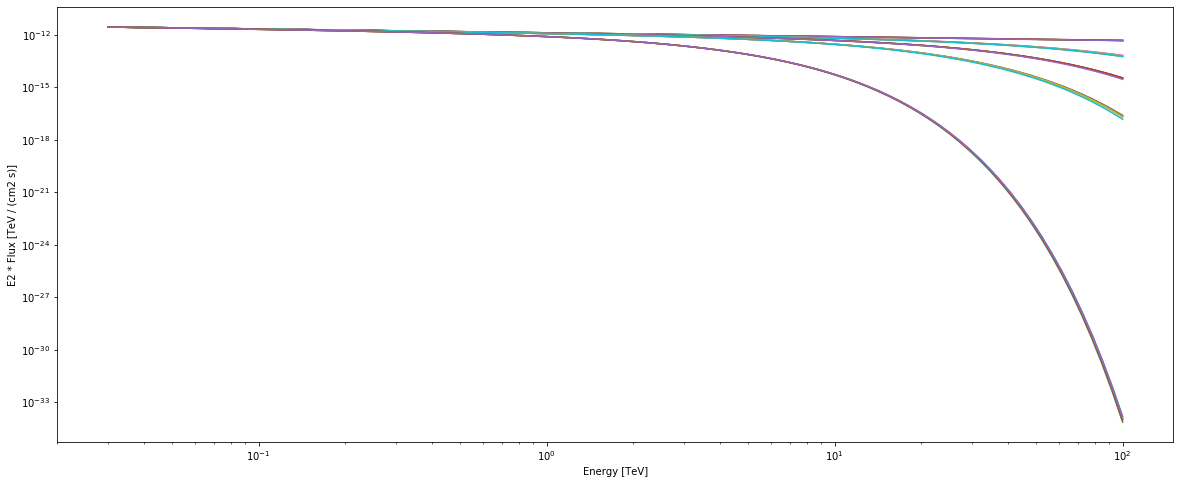

In [21]:
plt.figure(figsize=[20,8])
energy_range = [0.03, 100] * u.TeV
for j in range(5):
    for i in range(5):
        sim[i][j].plot(energy_range=energy_range, energy_power=2)
plt.show

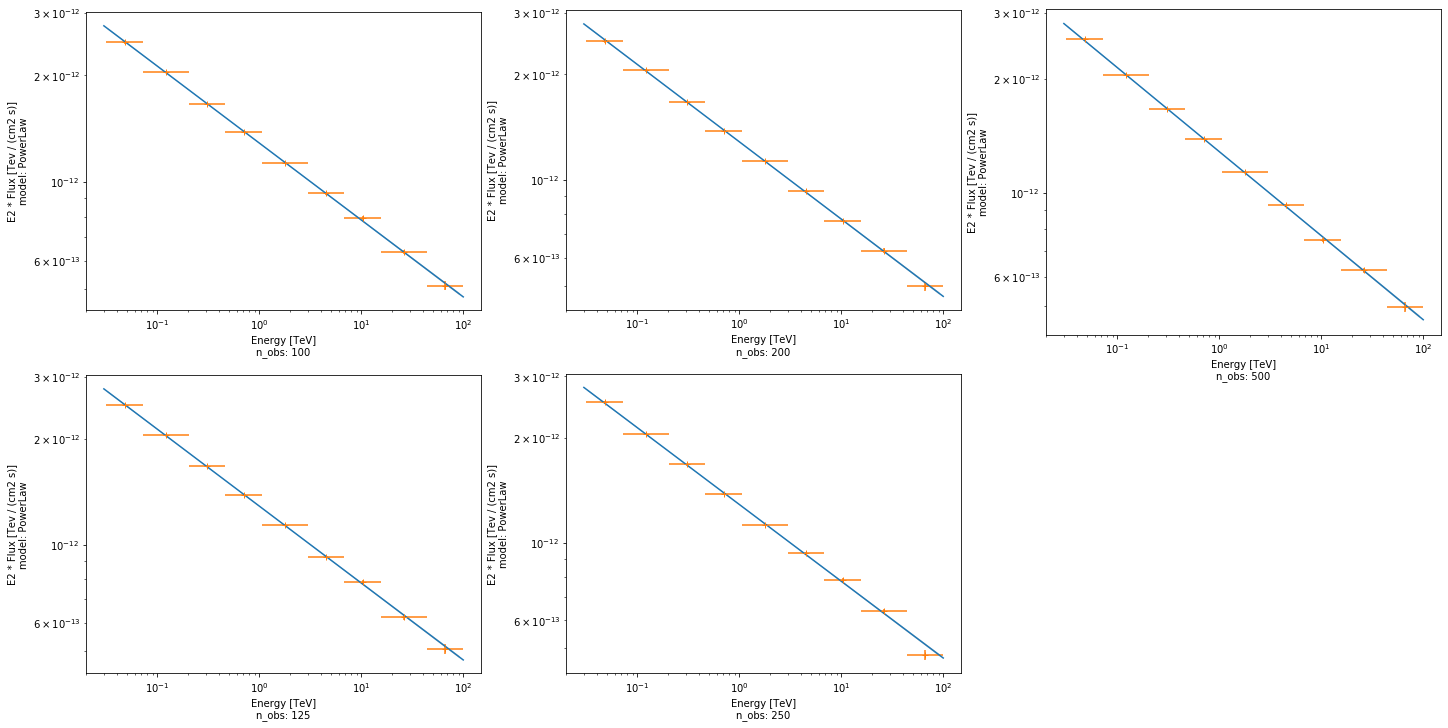

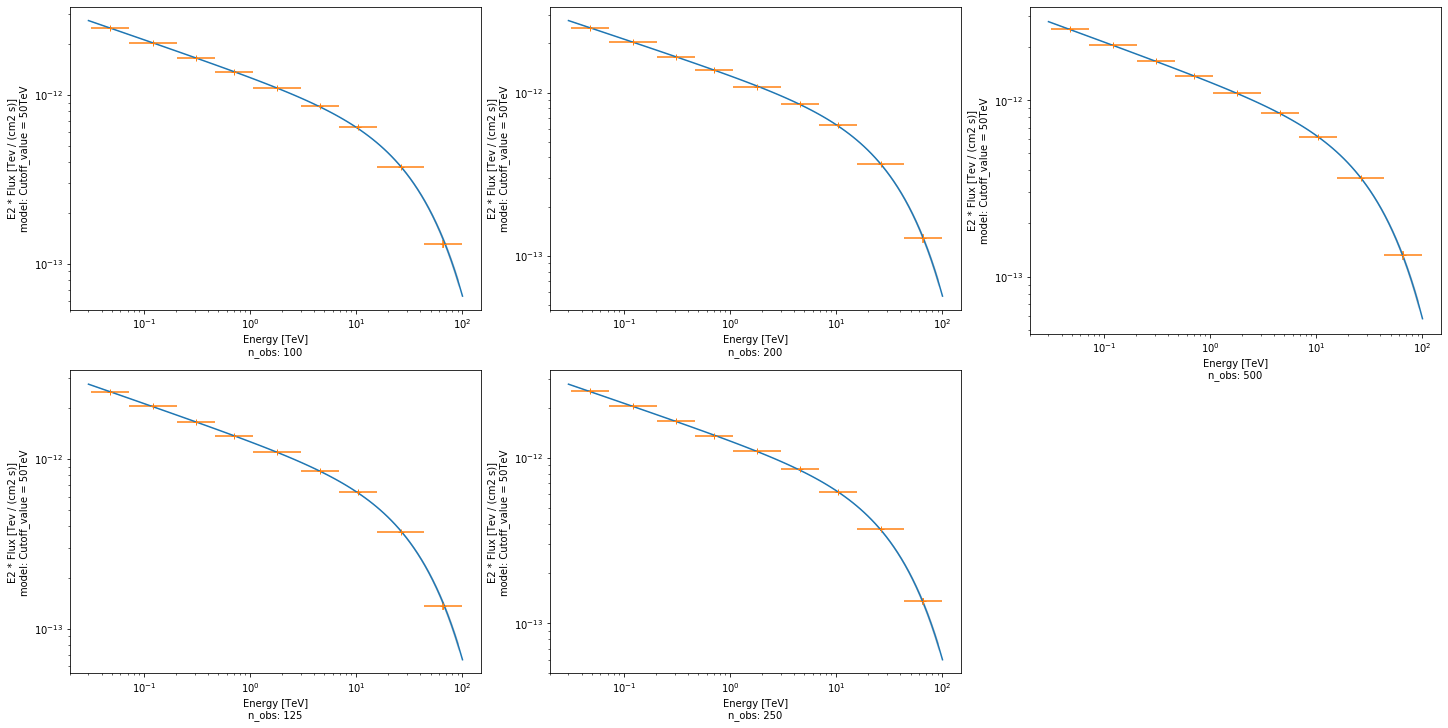

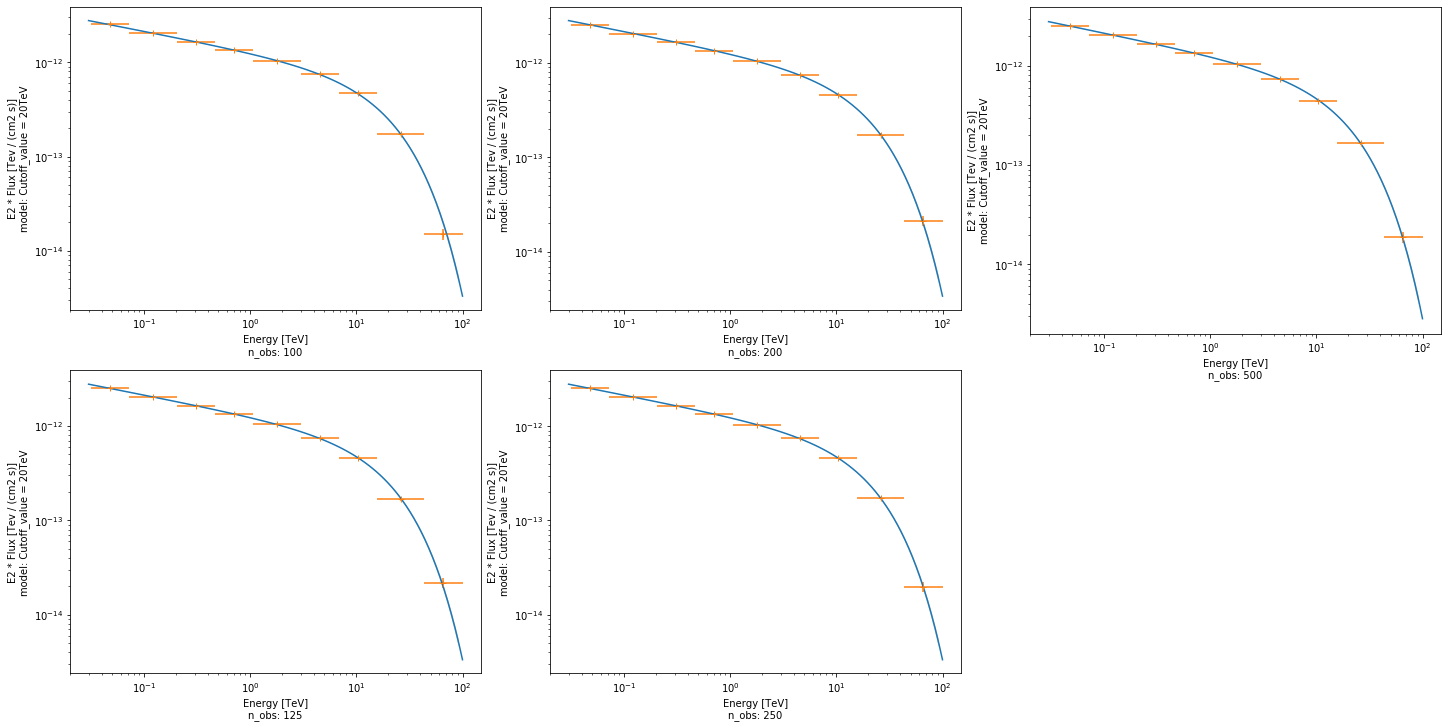

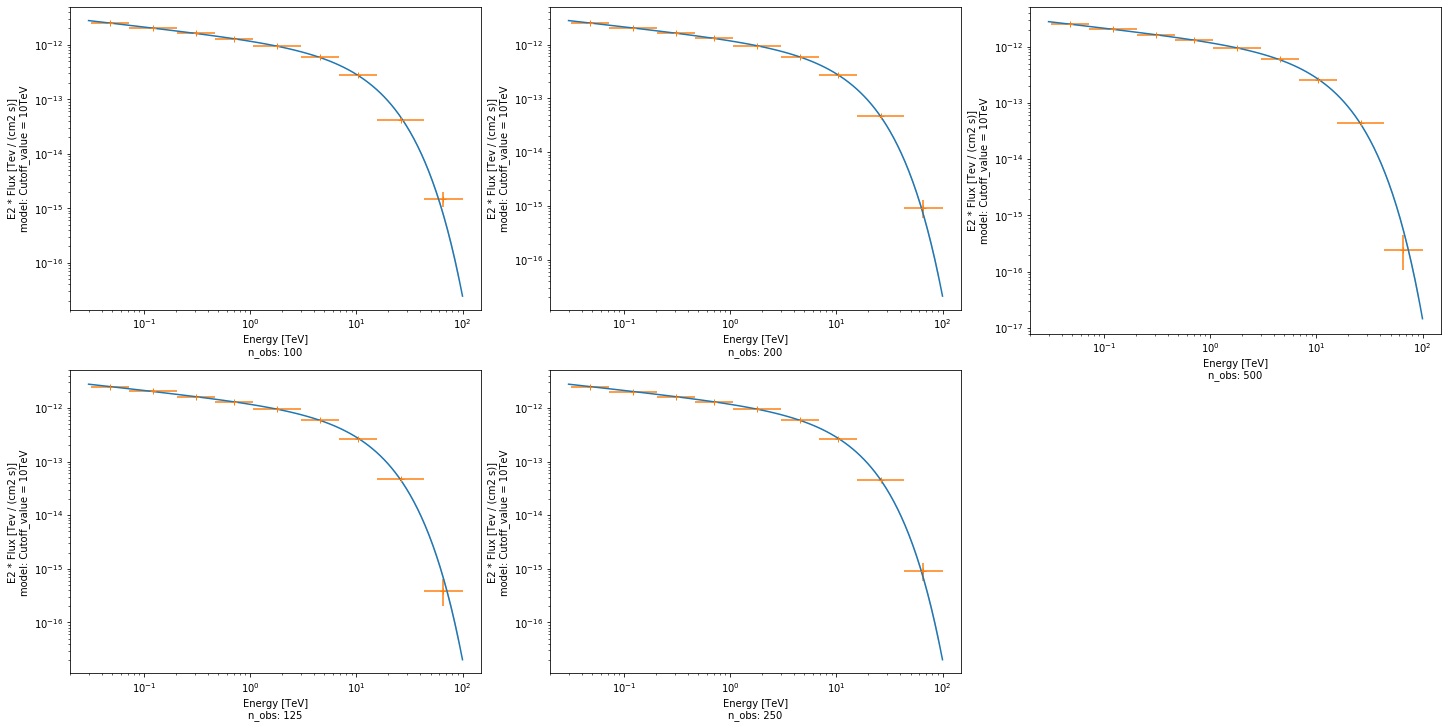

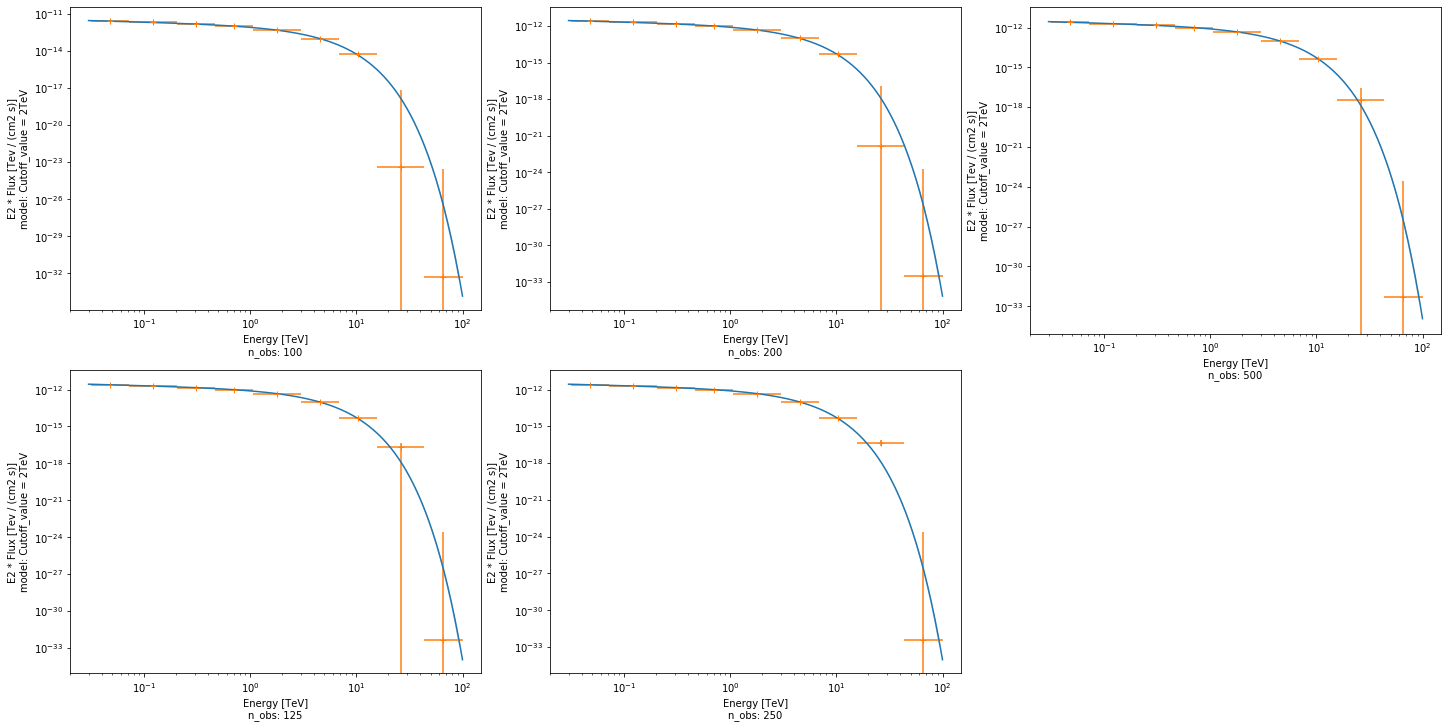

In [22]:
for i in range(5):    
    fig = plt.figure(figsize=[20,10],constrained_layout=True)

    import matplotlib.gridspec as gridspec

    gs0 = gridspec.GridSpec(1, 3, figure=fig)

    gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0])
    for n in range(2):
        ax = fig.add_subplot(gs1[n])
        sim[n][i].plot(energy_range=energy_range, energy_power=2)
        fpes[n][i].plot(energy_power=2)
        plot_error(self=sim[n][i], covar=results[n][i].parameters.covariance,energy_range=energy_range, energy_power=2)
        plt.xlabel(f'Energy [TeV]\nn_obs: {n_obs[n]}')
        plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {model_name[i]}')

    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
    for n in range(2):
        ax = fig.add_subplot(gs2[n])
        sim[n+2][i].plot(energy_range=energy_range, energy_power=2)
        fpes[n+2][i].plot(energy_power=2)
        plot_error(self=sim[n+2][i], covar=results[n+2][i].parameters.covariance,energy_range=energy_range, energy_power=2)
        plt.xlabel(f'Energy [TeV]\nn_obs: {n_obs[n+2]}')
        plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {model_name[i]}')

    gs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2])
    for n in range(1):
        ax = fig.add_subplot(gs3[n])
        sim[n+4][i].plot(energy_range=energy_range, energy_power=2)
        fpes[n+4][i].plot(energy_power=2)
        plot_error(self=sim[n+4][i], covar=results[n+4][i].parameters.covariance,energy_range=energy_range, energy_power=2)
        plt.xlabel(f'Energy [TeV]\nn_obs: {n_obs[n+4]}')
        plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {model_name[i]}')


    plt.show()

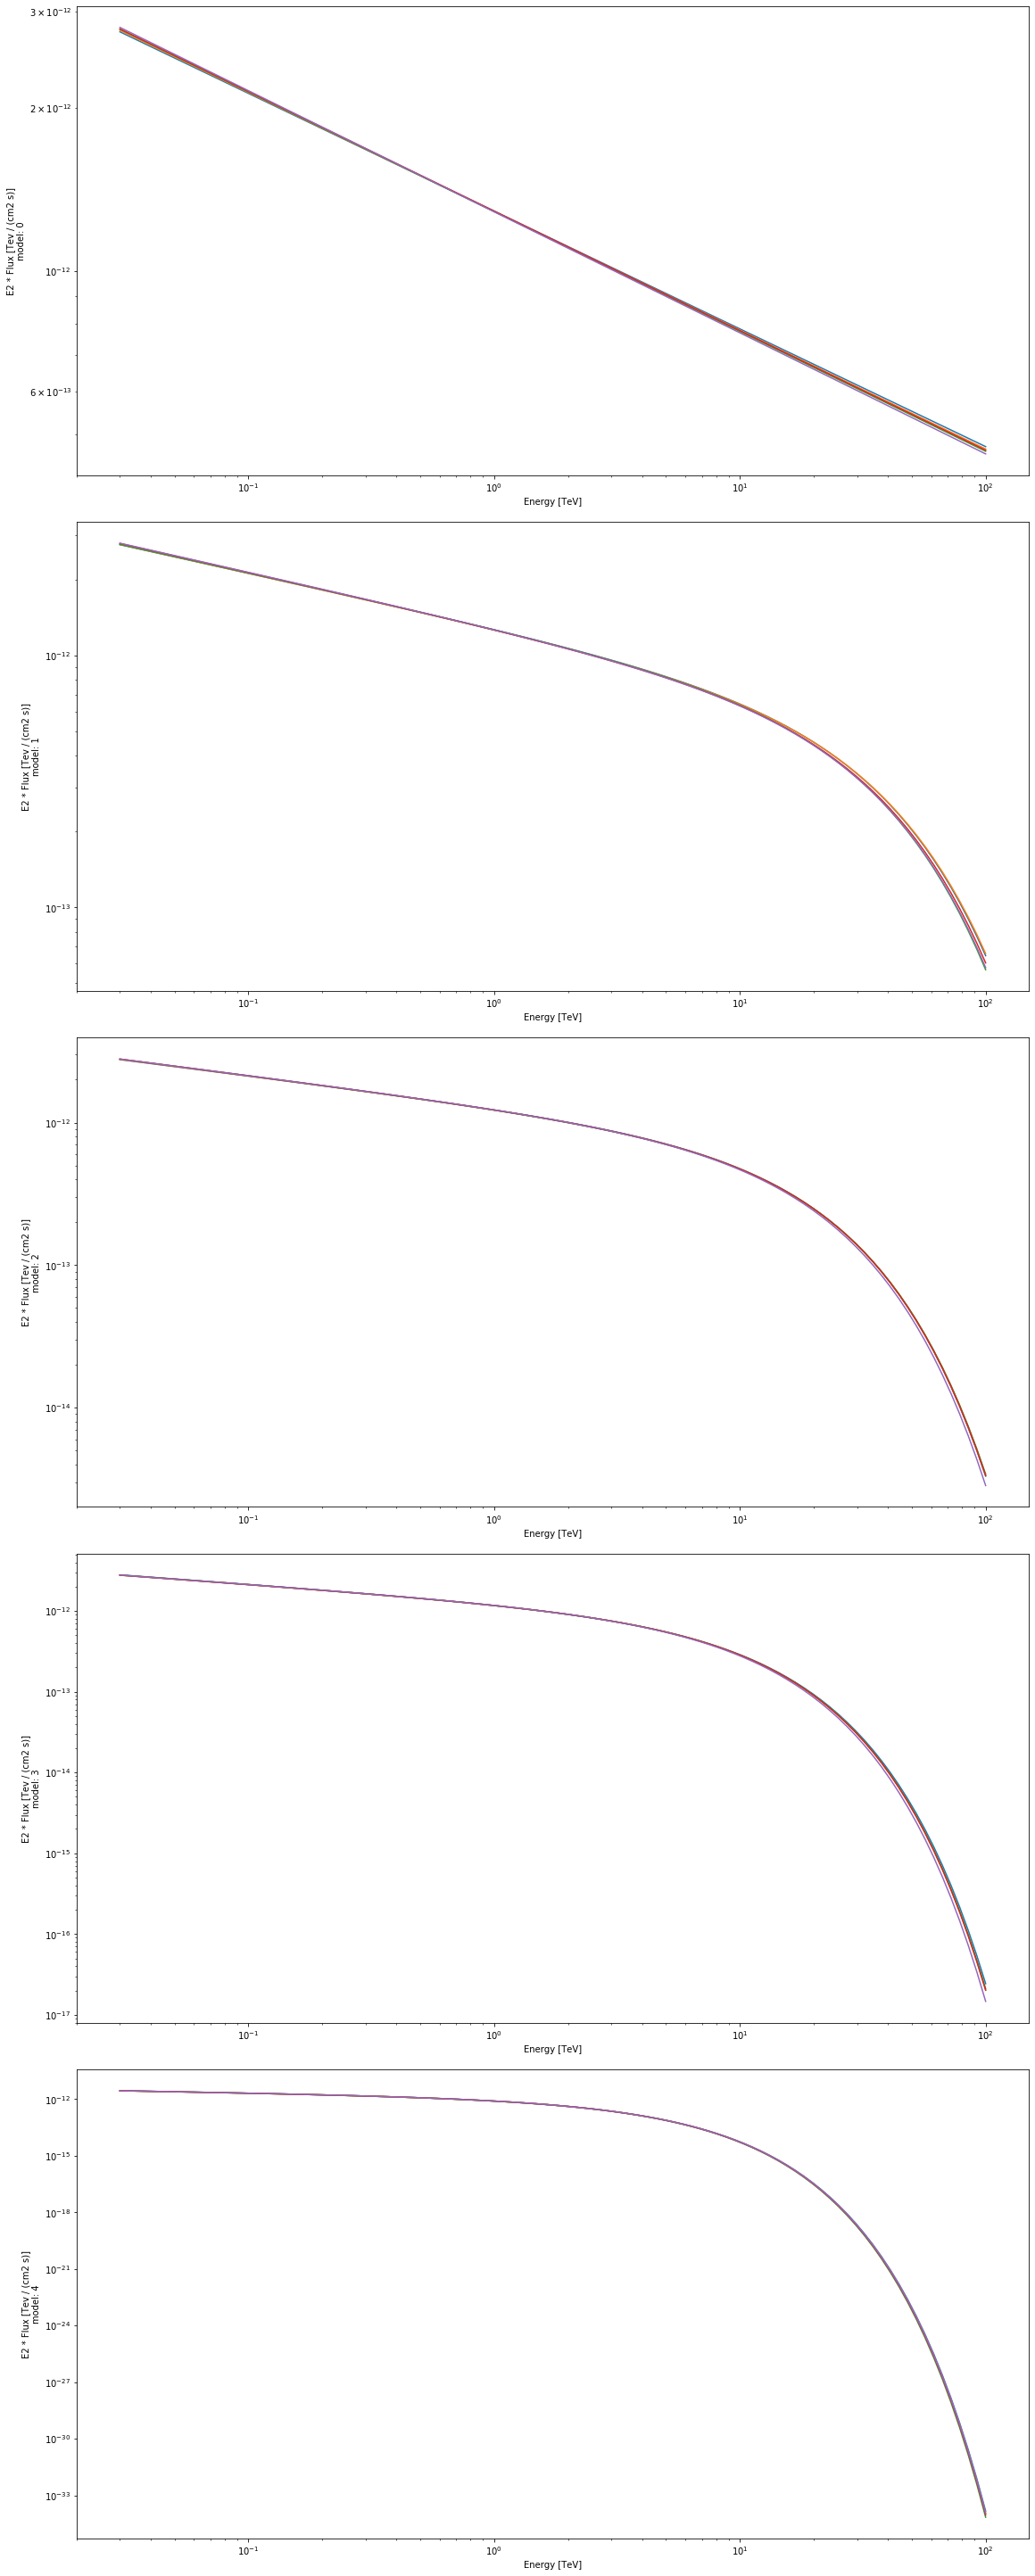

In [23]:
fig = plt.figure(figsize=[16,40],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 1, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0])
for n in range(5):
    ax = fig.add_subplot(gs1[n])
    for i in range(5):
        sim[i][n].plot(energy_range=energy_range, energy_power=2)
    plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {n}')
    
plt.show()

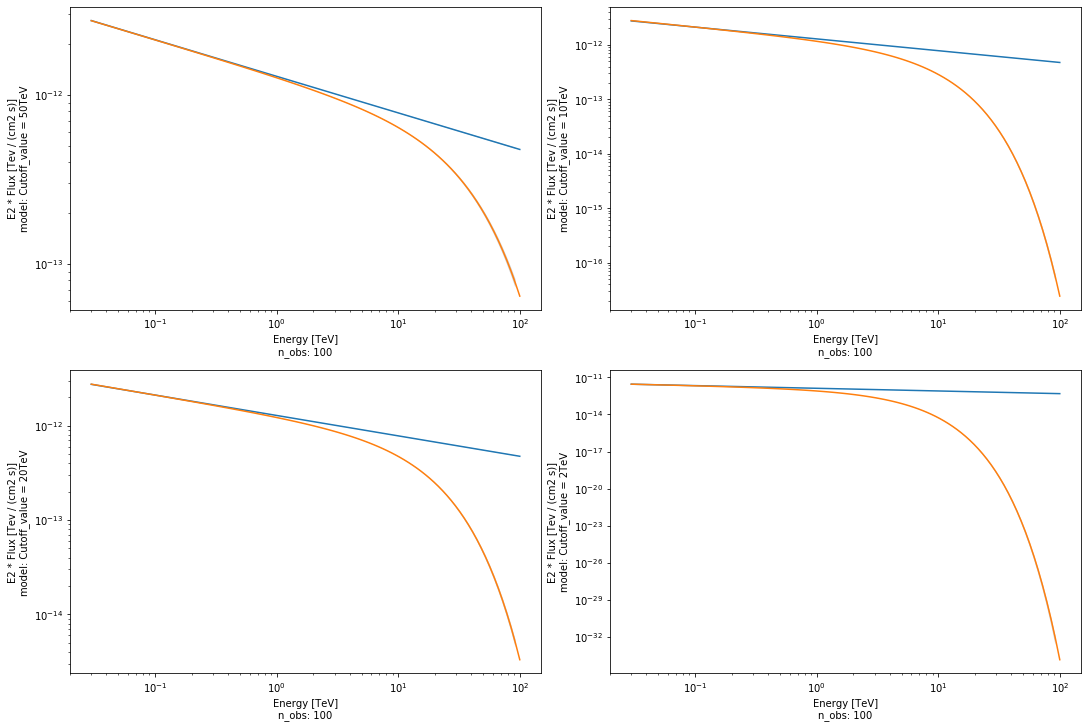

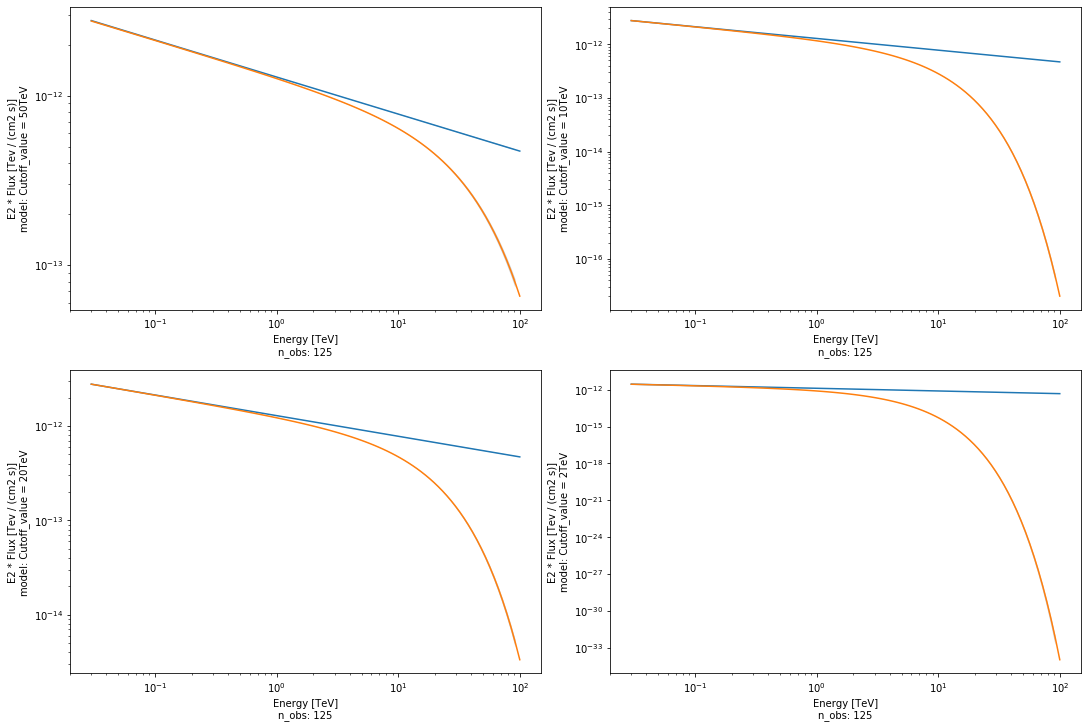

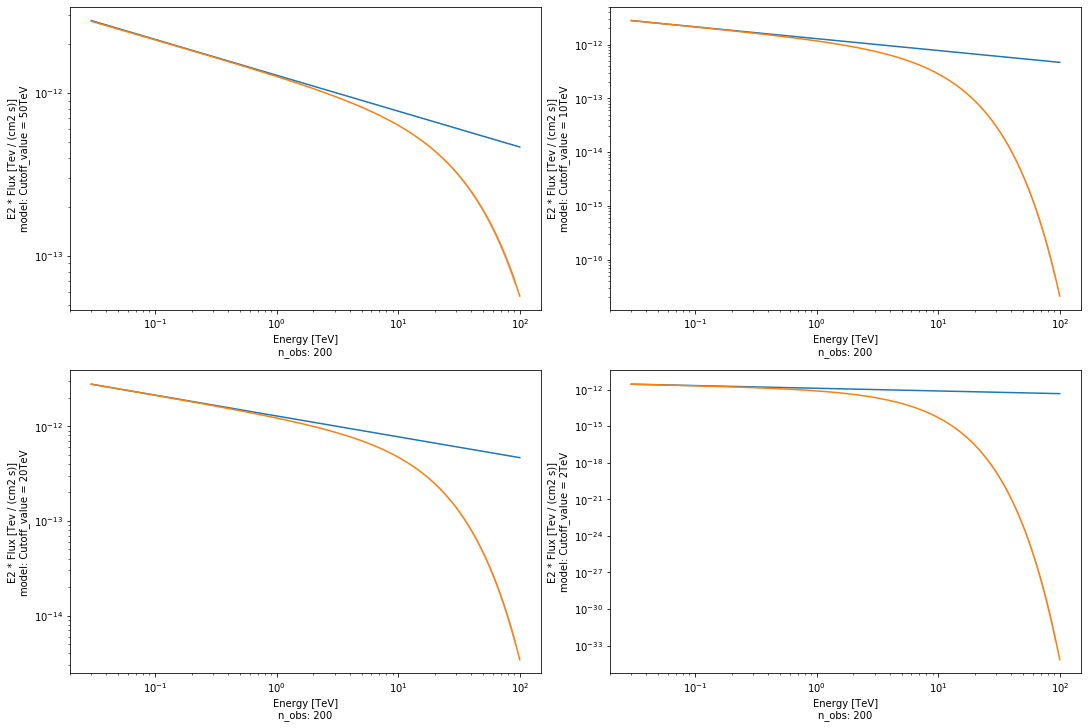

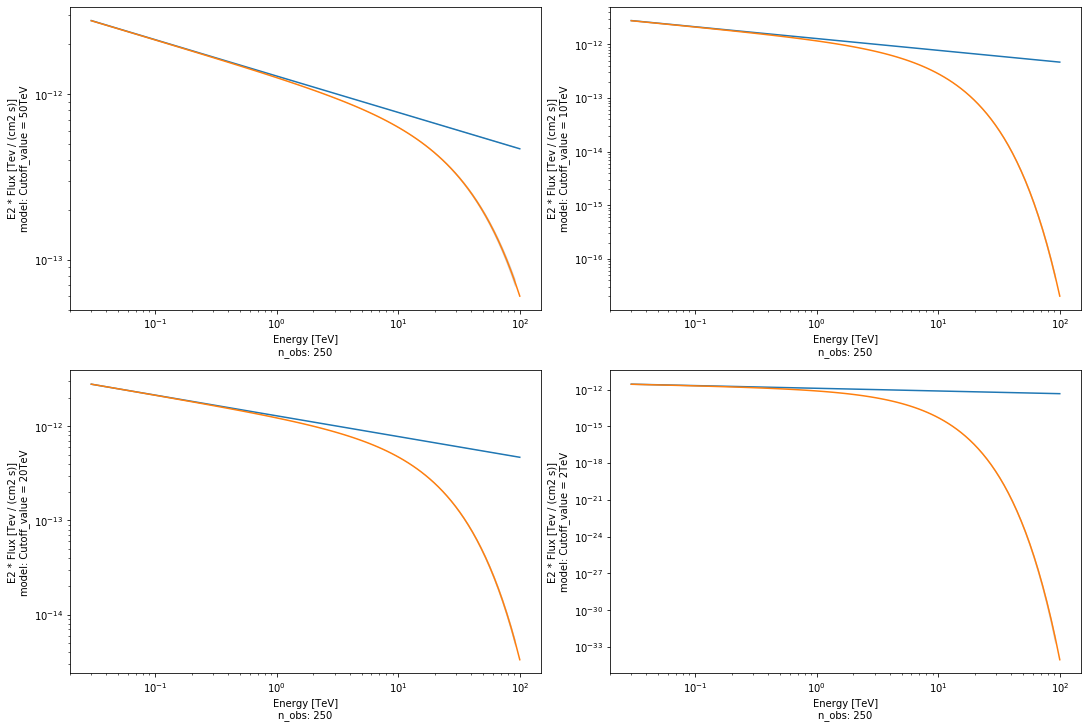

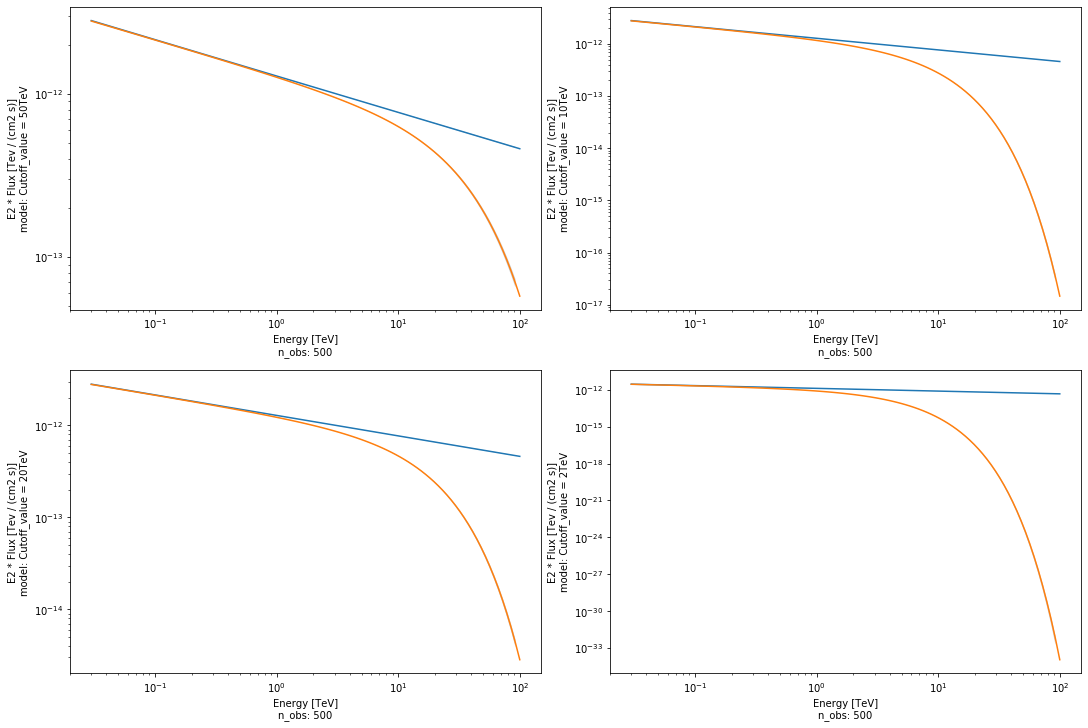

In [24]:
for i in range(5):    
    fig = plt.figure(figsize=[15,10],constrained_layout=True)

    import matplotlib.gridspec as gridspec

    gs0 = gridspec.GridSpec(1, 2, figure=fig)

    gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0])
    for n in range(2):
        ax = fig.add_subplot(gs1[n])
        sim[i][0].plot(energy_range=energy_range, energy_power=2)
        plot_error(self=sim[i][0], covar=results[i][0].parameters.covariance,energy_range=energy_range, energy_power=2)
        sim[i][n+1].plot(energy_range=energy_range, energy_power=2)
        plot_error(self=sim[i][n+1], covar=results[i][n+1].parameters.covariance,energy_range=energy_range, energy_power=2)
        plt.xlabel(f'Energy [TeV]\nn_obs: {n_obs[i]}')
        plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {model_name[n+1]}')

    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
    for n in range(2):
        ax = fig.add_subplot(gs2[n])
        sim[i][0].plot(energy_range=energy_range, energy_power=2)
        plot_error(self=sim[i][0], covar=results[i][0].parameters.covariance,energy_range=energy_range, energy_power=2)
        sim[i][n+3].plot(energy_range=energy_range, energy_power=2)
        plot_error(self=sim[i][n+3], covar=results[i][n+3].parameters.covariance,energy_range=energy_range, energy_power=2)
        plt.xlabel(f'Energy [TeV]\nn_obs: {n_obs[i]}')
        plt.ylabel(f'E2 * Flux [Tev / (cm2 s)]\nmodel: {model_name[n+3]}')


    plt.show()

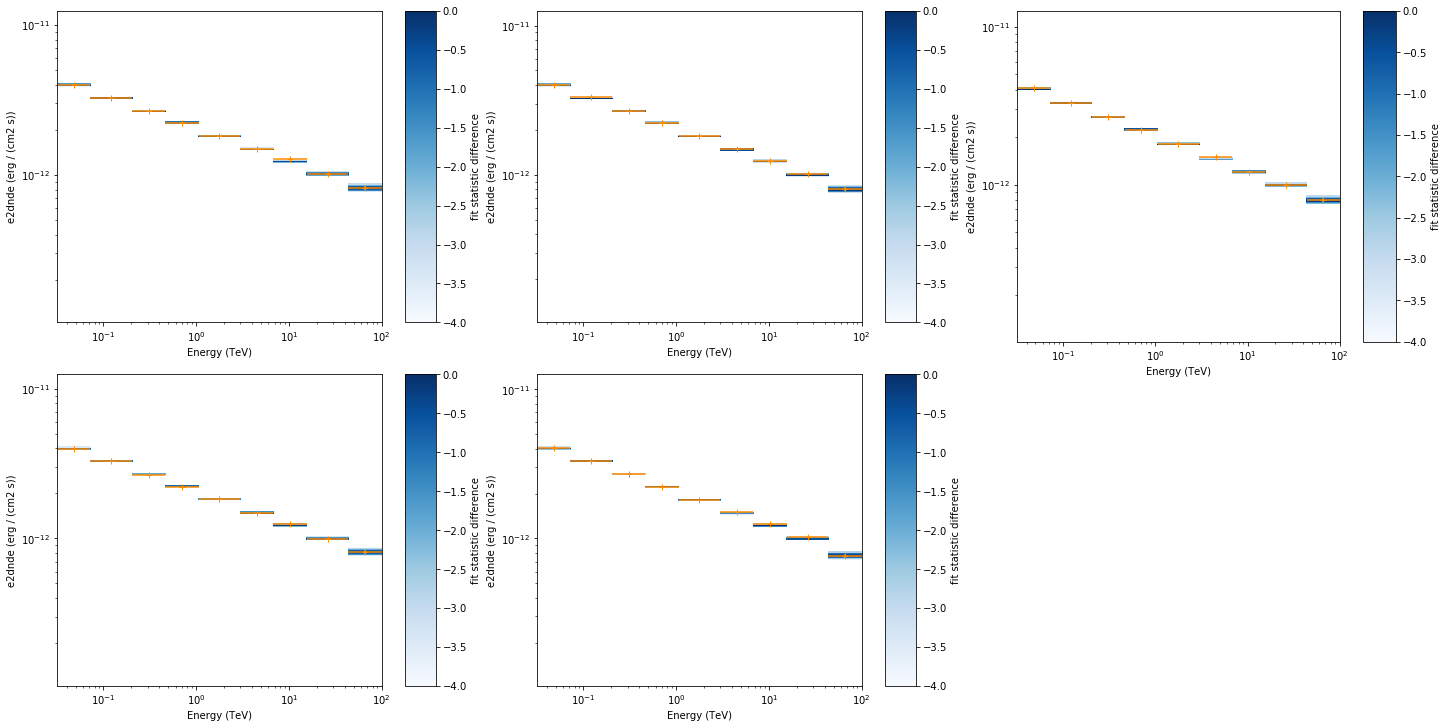

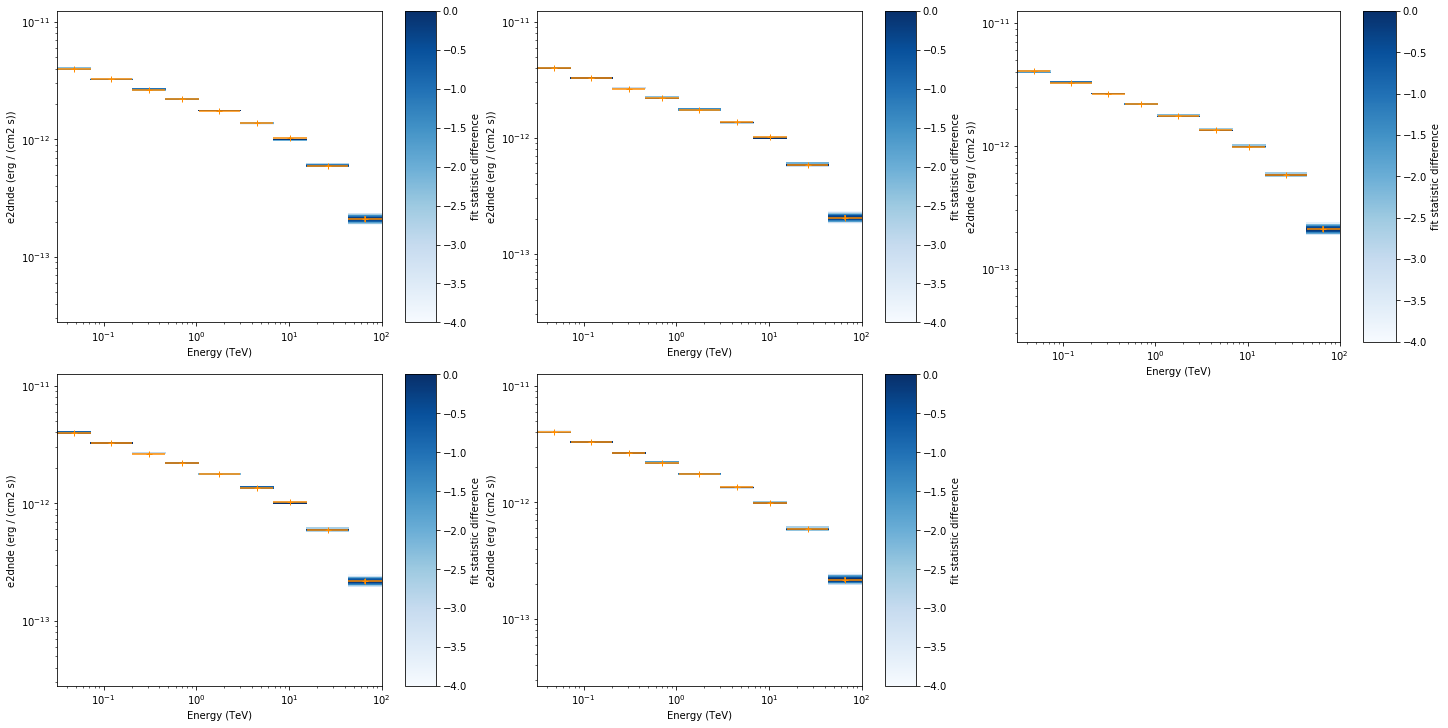

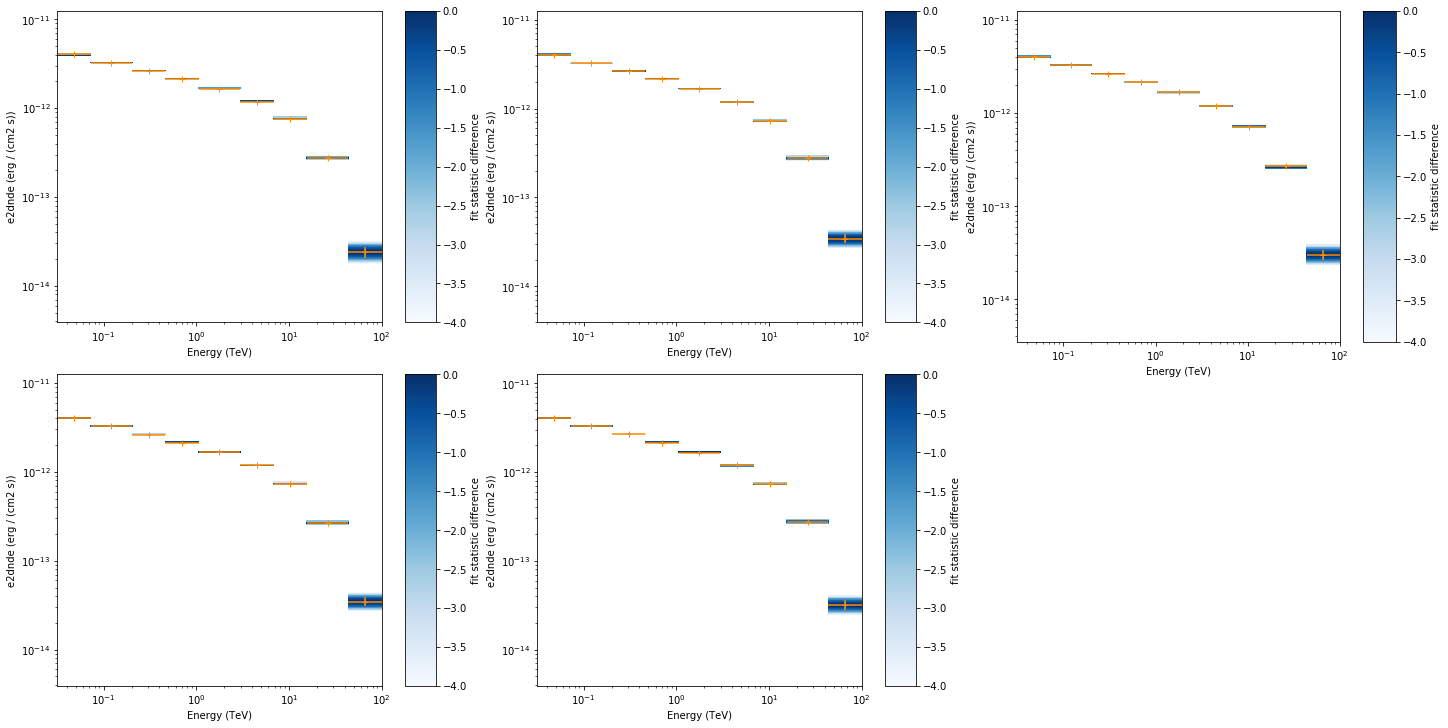

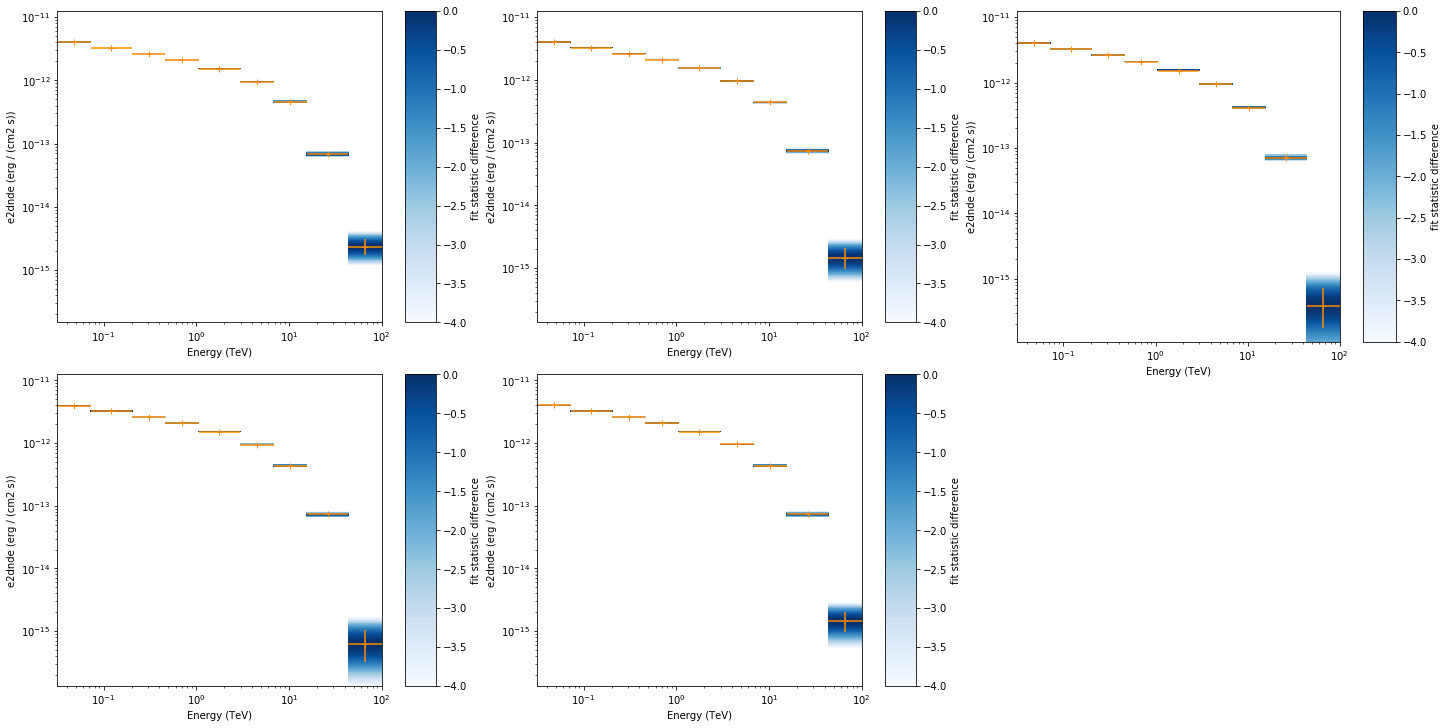

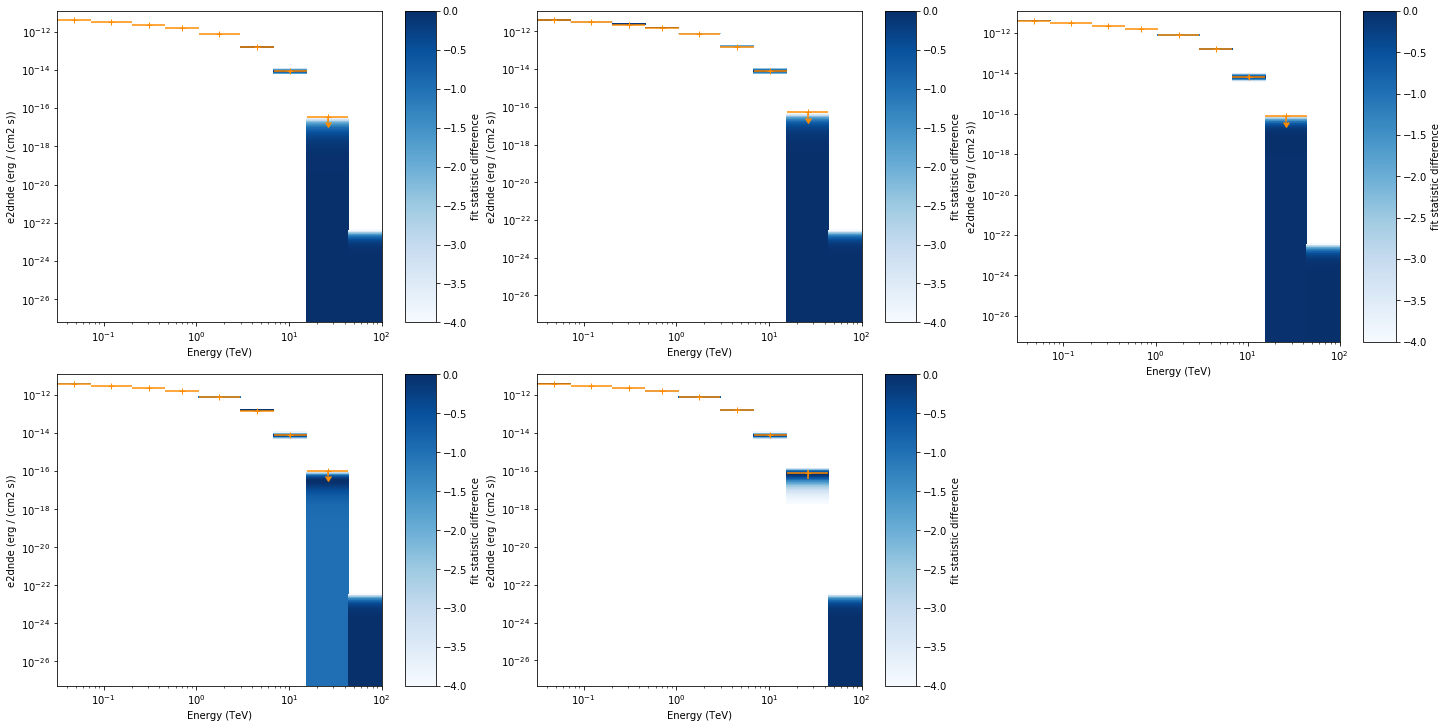

In [25]:
for i in range(5):    
    fig = plt.figure(figsize=[20,10],constrained_layout=True)

    import matplotlib.gridspec as gridspec

    gs0 = gridspec.GridSpec(1, 3, figure=fig)

    gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0])
    for n in range(2):
        ax = fig.add_subplot(gs1[n])
        fpes[n][i].table["is_ul"] = fpes[n][i].table["ts"] < 4
        axer = fpes[n][i].plot(
            energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
        )
        fpes[n][i].to_sed_type("e2dnde").plot_ts_profiles(ax=axer)

    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1])
    for n in range(2):
        ax = fig.add_subplot(gs2[n])
        fpes[n+2][i].table["is_ul"] = fpes[n+2][i].table["ts"] < 4
        axer = fpes[n+2][i].plot(
            energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
        )
        fpes[n+2][i].to_sed_type("e2dnde").plot_ts_profiles(ax=axer)

    gs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2])
    for n in range(1):
        ax = fig.add_subplot(gs3[n])
        fpes[n+4][i].table["is_ul"] = fpes[n+4][i].table["ts"] < 4
        axer = fpes[n+4][i].plot(
            energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
        )
        fpes[n+4][i].to_sed_type("e2dnde").plot_ts_profiles(ax=axer)


    plt.show()